<a href="https://colab.research.google.com/github/ignaciomontovio/TP-GPU-Parte2/blob/main/TP_Parte2_GPU_filtro_brillo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Introducción

El siguiente ejemplo modifica el color de una imágen parametrizada, cambiandole el brillo. El cálculo de la se realiza aplicando la siguiente formula a cada color RGB del pixel:

<center>$ brillocolor=colorpixel*(1+factordebrillo)$</center>

EL objetivo es enseñar el funcionamiento del Lenguaje Python, CUDA y el manejo de imagenes a bajo nivel. El ejemplo es ilustrativo, ya que internamente el módulo Pillow posee varios filtros integrados.

-----
#Enunciado del Ejercicio

a)  Teniendo en cuenta el código secuencial del Filtro de Brillo de una imagen, que se ejecuta en la CPU, genere el kernel para ejecutar el mismo algoritmo en forma paralela en la gpu

---
## 2 Armado del ambiente
Toma la direcciòn web de una imagen con  acceso público en internet, la deja disponible al contexto de ejecuciòn del cuaderno colab.

In [1]:
#@title # 2.1 Parámetros de ejecución
#@markdown ---
#@markdown ### Especifique la URL de la imagen:
url_imagen = "https://raw.githubusercontent.com/soa-pc-unlam/ProgramacionConcurrente/main/Enunciados%20TPs/TP-GPU/Imagenes/MK%201024x768.jpg" #@param {type:"string"}

#@markdown ---
# Leo la imagen desde internet.
#!wget https://github.com/wvaliente/SOA_HPC/blob/main/unlam.jpg?raw=true -O imagen.jpg

# TODO: Mejorar informaciòn y resutlado de ejecución.
!wget {url_imagen} -O imagen.jpg



--2023-11-15 15:35:57--  https://raw.githubusercontent.com/soa-pc-unlam/ProgramacionConcurrente/main/Enunciados%20TPs/TP-GPU/Imagenes/MK%201024x768.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 151790 (148K) [image/jpeg]
Saving to: ‘imagen.jpg’

imagen.jpg          100%[===================>] 148.23K  --.-KB/s    in 0.02s   

2023-11-15 15:35:57 (7.44 MB/s) - ‘imagen.jpg’ saved [151790/151790]



---
## 2.2 Instala en el cuaderno el módulo CUDA de Python.

In [2]:
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.2 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2023.1-cp310-cp310-linux_x86_64.whl size=661263 sha256=6e80d7c02b31afbbb52cf9fe40b9aa53044ffdd38f2917d415c9f2dc13a5408d
  Stored in directory: /root/.cache/pip/wheels/46/65/06/b997165edd2fd9690c3497ca54ea4485b571d7bd959c21c6c4
Successfully built pycuda


---
# 3 Desarrollo
# Ejecución en CPU
Ejecución del algoritmo del filtro de brllo ejecutandose en form secuencial en  la CPU

Ingrese la cantidad de brillo: (-1.0 a 1.0): 0.5
imagen original


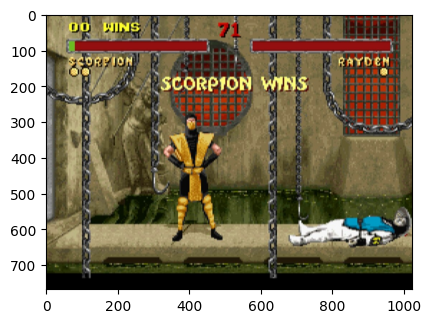

imagen con filtro


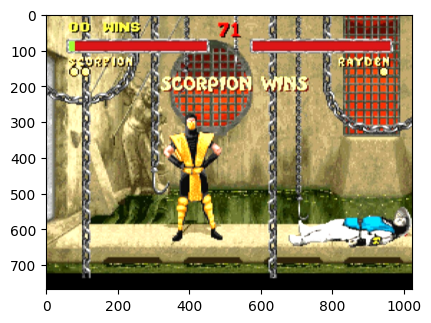

         9437217 function calls in 6.698 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    1.350    1.350    6.698    6.698 <ipython-input-6-787fa19ec148>:26(filter_brightness)
   786432    0.694    0.000    2.195    0.000 Image.py:1570(getpixel)
   786432    0.937    0.000    2.041    0.000 Image.py:1944(putpixel)
  1572865    1.203    0.000    1.504    0.000 Image.py:835(load)
   786432    0.553    0.000    1.288    0.000 ImageFile.py:155(load)
  2359296    1.111    0.000    1.111    0.000 <ipython-input-6-787fa19ec148>:15(bounded_pixel_value)
   786432    0.329    0.000    0.329    0.000 {method 'putpixel' of 'ImagingCore' objects}
  1572864    0.301    0.000    0.301    0.000 {method 'pixel_access' of 'ImagingCore' objects}
   786432    0.213    0.000    0.213    0.000 {method 'getpixel' of 'ImagingCore' objects}
        3    0.006    0.002    0.006    0.002 {method 'decode' of 'ImagingDecoder' objects}
   

In [6]:
from pickle import FALSE
from PIL import Image
import matplotlib.pyplot as plt

import cProfile

#Poner SHOW_STATS en true para ver el tiempo de ejecucion y false para ocultarlo
SHOW_STATS=True

CM= 1/2.54
SIZE= 12*CM


#funcion que escala el valor del brillo
def bounded_pixel_value(color, brightness_factor):
	scaled_value = float(color * (1 + brightness_factor))

	if scaled_value < 0:
		return 0
	elif scaled_value > 255:
		return 255

	return int(scaled_value)

#funcion que aplica el filtro del brillo
def filter_brightness(im,out,brightness_factor):

  width, height = im.size

  for x in range(width):
      for y in range(height):
          r,g,b = im.getpixel((x,y))

          updatedR = bounded_pixel_value(r, brightness_factor)
          updatedG = bounded_pixel_value(g, brightness_factor)
          updatedB = bounded_pixel_value(b, brightness_factor)

          out.putpixel((x,y), (updatedR, updatedG, updatedB))
  return out

def main():
  #objeto del Profiler de python
  cprofiler = cProfile.Profile()

  #se carga la imagen
  im = Image.open("imagen.jpg")
  out = Image.new('RGB', im.size, 0xffffff)


  brightness_factor = float(input("Ingrese la cantidad de brillo: (-1.0 a 1.0): "))

  #se activa el profiler
  cprofiler.enable()

  #se aplica el filtro
  out= filter_brightness(im, out,brightness_factor)

  #se desactiva el profiler
  cprofiler.disable()

  out.save('brightnessScaled.jpg')

  #se muestra la imagen original
  print("imagen original")
  plt.figure(figsize=(SIZE,SIZE))
  imgplot=plt.imshow( im)
  plt.show()

  #se muestra la imagen con filtro
  print("imagen con filtro")
  plt.figure(figsize=(SIZE,SIZE))
  img2plot=plt.imshow( out)
  plt.show()


  cprofiler.print_stats(sort='cumulative') if SHOW_STATS==True else None
main()

# Ejecución en GPU
Ejecución del algoritmo del filtro de brllo ejecutandose en forma paralaela en  la GPU

Imagen del filtro: imagen.jpg -RGB- [1024, 768]
Thread: [ 32 , 32  ], Bloque : [ 32 , 24 ]
Total de Thread: [ 1024 , 768  ]  =  786432


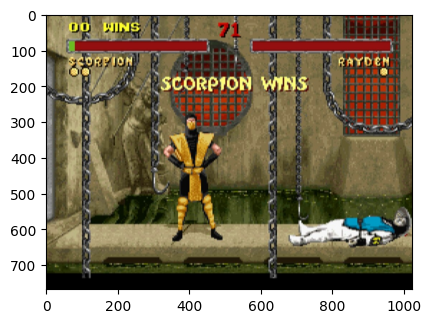

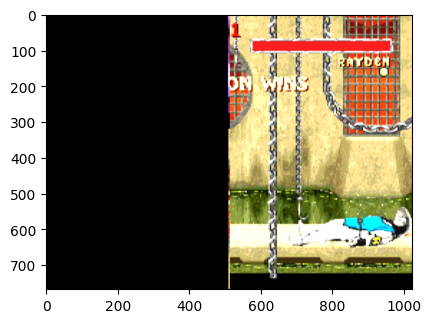

In [41]:
#%%writefile filter_brightness.py
%matplotlib inline
from datetime import datetime
tiempo_total = datetime.now()

import matplotlib.pyplot as plt
import numpy
from PIL import Image
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# --------------------------------------------

#BRIGHTNESS_FACTOR  debe ser entre -1 y 1
BRIGHTNESS_FACTOR = 1

CM= 1/2.54
SIZE= 12*CM

def define_kernel():
  module=SourceModule("""
        #define PIXEL_ROJO( x,y) (x + (y*ancho)) * 3
        #define PIXEL_VERDE(x,y) PIXEL_ROJO(x,y) + 1
        #define PIXEL_AZUL( x,y) PIXEL_ROJO(x,y) + 2

        __device__ int bounded_pixel_value(int color, float brightness_factor)
        {
          float scaled_value = (int)(color * (1 + brightness_factor));
          if (scaled_value < 0)
          {
            return 0;
          }
          else if (scaled_value > 255)
          {
            return 255;
          }
          return (int) scaled_value;
        }

        __global__ void kernel_img( int ancho, int alto, int *img_O, int *img_R, float brightness_factor )
        {
          // Calculo las coordenadas del Thread en dos dimensiones.
          int idx = threadIdx.x + blockIdx.x*blockDim.x;
          int idy = threadIdx.y + blockIdx.y*blockDim.y;

          // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
          /*
            Punto.C: Con (idx > ancho/2) le indico que procese solo la mitad derecha de la imagen
          */
          if((idx < ancho) && (idy< alto) && (idx > ancho/2))
          {
            float r = (float) img_O[ PIXEL_ROJO (idx, idy) ];
            float g = (float) img_O[ PIXEL_VERDE(idx, idy) ];
            float b = (float) img_O[ PIXEL_AZUL (idx, idy) ];

            int updatedR = bounded_pixel_value(r, brightness_factor);
            int updatedG = bounded_pixel_value(g, brightness_factor);
            int updatedB = bounded_pixel_value(b, brightness_factor);

            img_R[ PIXEL_ROJO (idx, idy) ] = updatedR;
            img_R[ PIXEL_VERDE(idx, idy) ] = updatedG;
            img_R[ PIXEL_AZUL (idx, idy) ] = updatedB;
          }
        }
        """)
  return module

def main():
  img_nombre = 'imagen.jpg'
  image = Image.open( img_nombre )

  # summarize some details about the image
  img_ancho, img_alto  = image.size

  # Convierto la imagen comprimida en JPEG/PNG a array
  img_O_cpu = numpy.asarray(image)
  img_O_cpu = img_O_cpu.astype( numpy.int32() )
  img_R_cpu = numpy.empty_like( img_O_cpu)

  # Reservo los 2 vectores en GPU(3 pixeles usa RGB * (el tamaño del array))
  img_O_gpu = cuda.mem_alloc( img_O_cpu.nbytes )
  img_R_gpu = cuda.mem_alloc( img_R_cpu.nbytes )

  # GPU - Copio la memoria al GPU.
  cuda.memcpy_htod( img_O_gpu, img_O_cpu )
  cuda.memcpy_htod( img_R_gpu, img_R_cpu )

  # CPU - Defino la función kernel que ejecutará en GPU.
  module = define_kernel()


  # Muestro los atributos de la imagen y como se ve antes del seudo filtro.
  print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )

  # CPU - Genero la función kernel.
  kernel = module.get_function("kernel_img")

  dim_hilo_x = 32
  dim_bloque_x = int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )
  dim_hilo_y = 32
  dim_bloque_y = int( (img_alto+dim_hilo_y-1) / dim_hilo_y )
  print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
  print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )


  kernel( numpy.int32(img_ancho), numpy.int32(img_alto), img_O_gpu, img_R_gpu, numpy.float32(BRIGHTNESS_FACTOR), block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y, 1) )

  # GPU - Copio el resultado desde la memoria GPU.
  cuda.memcpy_dtoh( img_R_cpu, img_R_gpu )

  # Muestro la imagen Original el filtro.
  plt.figure(figsize=(SIZE,SIZE))
  imgplot=plt.imshow( img_O_cpu )

  # Muestro la imagen luego de aplicarle el filtro.
  plt.figure(figsize=(SIZE,SIZE))
  imgplot=plt.imshow( img_R_cpu )

main()

In [40]:
!nvprof python filter_brightness.py

==9102== NVPROF is profiling process 9102, command: python3 filter_brightness.py
Imagen del filtro: imagen.jpg -RGB- [1024, 768]
Thread: [ 32 , 32  ], Bloque : [ 32 , 24 ]
Total de Thread: [ 1024 , 768  ]  =  786432
==9102== Profiling application: python3 filter_brightness.py
==9102== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   63.67%  6.5910ms         1  6.5910ms  6.5910ms  6.5910ms  [CUDA memcpy DtoH]
                   35.36%  3.6600ms         2  1.8300ms  1.8139ms  1.8462ms  [CUDA memcpy HtoD]
                    0.97%  100.25us         1  100.25us  100.25us  100.25us  kernel_img
      API calls:   69.64%  104.54ms         1  104.54ms  104.54ms  104.54ms  cuCtxCreate
                   21.17%  31.773ms         1  31.773ms  31.773ms  31.773ms  cuCtxDetach
                    5.67%  8.5137ms         1  8.5137ms  8.5137ms  8.5137ms  cuMemcpyDtoH
                    2.72%  4.0860ms         2  2.0430ms  1.9655ms 

# Código para saber el maximo tamaño de bloque soportado:

In [18]:
!git clone https://github.com/NVIDIA/cuda-samples.git
!cd cuda-samples/Samples/1_Utilities/deviceQuery/; make >/dev/null
!cuda-samples/Samples/1_Utilities/deviceQuery/deviceQuery | grep "Max dimension"

Cloning into 'cuda-samples'...
remote: Enumerating objects: 17263, done.
remote: Counting objects: 100% (17263/17263), done.
remote: Compressing objects: 100% (2115/2115), done.
remote: Total 17263 (delta 15225), reused 17041 (delta 15116), pack-reused 0
Receiving objects: 100% (17263/17263), 132.94 MiB | 27.50 MiB/s, done.
Resolving deltas: 100% (15225/15225), done.
Updating files: 100% (3998/3998), done.
  Max dimension size of a thread block (x,y,z): (1024, 1024, 64)
  Max dimension size of a grid size    (x,y,z): (2147483647, 65535, 65535)


#Respuestas:
a)
Bloque (16, 19, 1)

CPU
```
ncalls  tottime  cumtime  filename:lineno(function)
   1     1.359    6.374   <ipython-input-3-787fa19ec148>:26(filter_brightness)
```
GPU
```
Calls    Time         Avg          Name
  1     84.063us    84.063us    kernel_img
```

Bloque (24, 24, 1)

CPU
```
ncalls  tottime  cumtime  filename:lineno(function)
  1     1.359    6.374   <ipython-input-3-787fa19ec148>:26(filter_brightness)
```
GPU
```
Calls    Time         Avg          Name
  1     111.33us    111.33us     kernel_img
```

Maximo Bloque soportado (1024, 1024, 1):

CPU
```
ncalls  tottime  cumtime  filename:lineno(function)
  1     1.359    6.374   <ipython-input-3-787fa19ec148>:26(filter_brightness)
```
GPU
```
Calls    Time         Avg          Name
  1     100.03us    100.03us     kernel_img
```

b) Lo primero que se observa es que el procesamiento en la gpu es muchísimo más rápido que en cpu. Despues también se ve que para esta imagen y su resolución hay un tamaño de bloque que tiene mejor performance que simplemente asignar un bloque lo mas grande posible.





---
# 4 Tabla de pasos


 Procesador | Funciòn | Detalle
------------|---------|----------
CPU      |  wget url_imagen       | Lectura de la direcciòn URL de la imagen (jpg) a procesar.
CPU      | pip install pycuda    | Instala en el cuaderno los driver de CUDA para Python.
CPU      |  matplotlib inline    | Macro de Colab para mostrar imagenes.
CPU      |  import                | Importa los módulos para funcionar.
CPU      |  datetime.now()        | Toma el tiempo actual.
CPU      |  Image.open()          | Abre el archivo de la imagen.
CPU      |  numpy.asarray(imagen) | Convierte el formato comprimido JPG a RAW.
CPU      |  numpy.empty_like(()   | Genera el array destino, que tendrá a la imagen resultado.
**GPU**  |  cuda.mem_alloc()      | Reserva la memoria para las imagenes en GPU.
**GPU**  |  cuda.memcpy_htod()    | Copio los valores en crudo de las imagenes al GPU.
CPU      |  SourceModule()        | Posee el còdigo del kernel.
CPU      |  module.get_function() | convierte el texto del kernel en funcion de Python.
CPU      |  dim_hilo_x, dim_hilo_y| Calcula las dimensiones para la ejecuciòn de 2D.
**GPU**  |  kernel()              | Ejecuta el kernel en GPU, enviando los parametros.
CPU      |  print()               | Informa los atributos de la imagen.
CPU      | cuda.memcpy_dtoh()     | Copia desde la memoria GPU al CPU.
CPU      |  plt.imshow            | Muestra la imagen original.
CPU      |  plt.imshow            | Muestra la imagen resultado.



---
# 5 Conclusiones

Las conclusiones son explicadas en clase...

---
# 6 Bibliografía

[1] MARKDOWN SYNTAX Colab: [PDF](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/markdown-cheatsheet-online.pdf)

[2] Introducción a Python: [Página Colab](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/Python_Basico.ipynb)

[3] Tutorial Point Colab: [PDF](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/markdown-cheatsheet-online.pdf)

[4] Algoritmo de filtro brillo en forma secuencial [PDF](https://hackernoon.com/es/algoritmos-de-procesamiento-de-imagen-ajuste-de-contraste-y-brillo-de-imagen-0y4y318a)
